<a href="https://colab.research.google.com/github/fikrifaizz/BPDS-SubmissionAkhir/blob/main/notebooks/01_data_exploration_%26_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("/content/drive/MyDrive/Self Project/Crypto Price Prediction/data/raw/btcusd_1-min_data.csv")
data

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
1,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
2,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
3,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
4,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
...,...,...,...,...,...,...
7281752,1.762387e+09,103975.00,103975.00,103882.00,103892.00,2.010327
7281753,1.762387e+09,103897.00,103926.00,103883.00,103884.00,0.108666
7281754,1.762387e+09,103869.00,103889.00,103851.00,103888.00,0.603795
7281755,1.762387e+09,103881.00,103892.00,103874.00,103892.00,0.348672


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7281757 entries, 0 to 7281756
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(6)
memory usage: 333.3 MB


In [4]:
data.shape

(7281757, 6)

In [5]:
data.isnull().sum()

,0
Timestamp,0
Open,0
High,0
Low,0
Close,0
Volume,0


In [6]:
data.duplicated().sum()

np.int64(0)

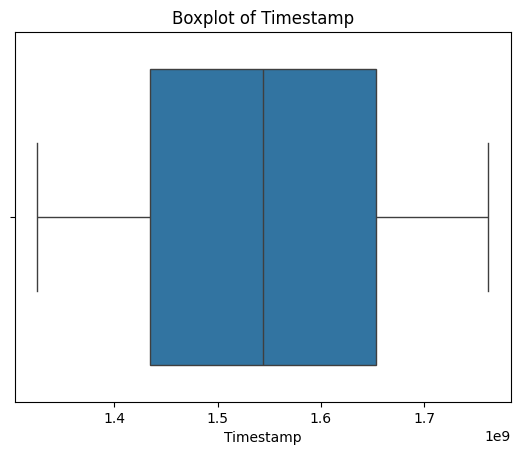

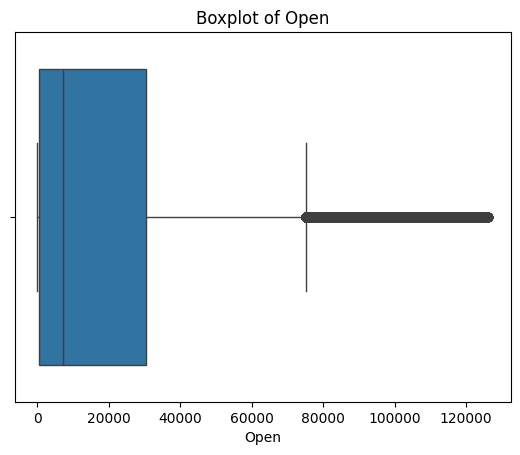

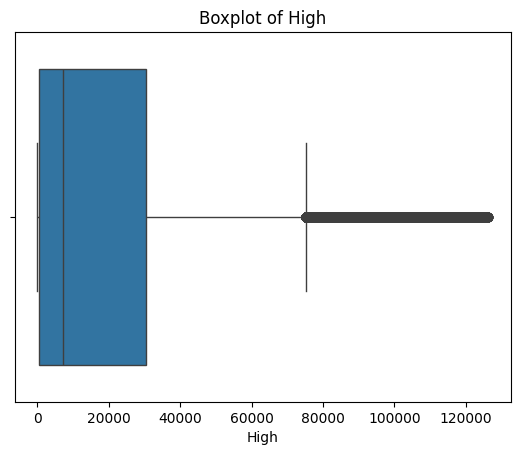

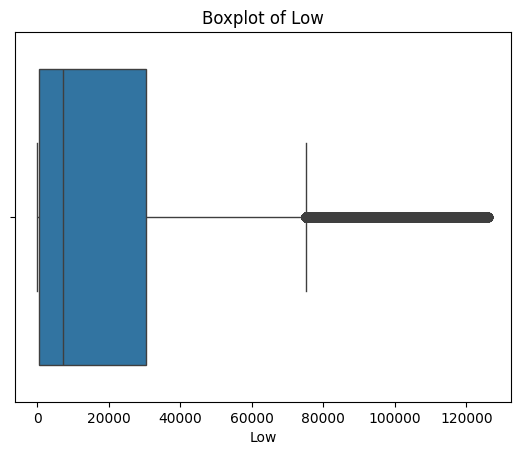

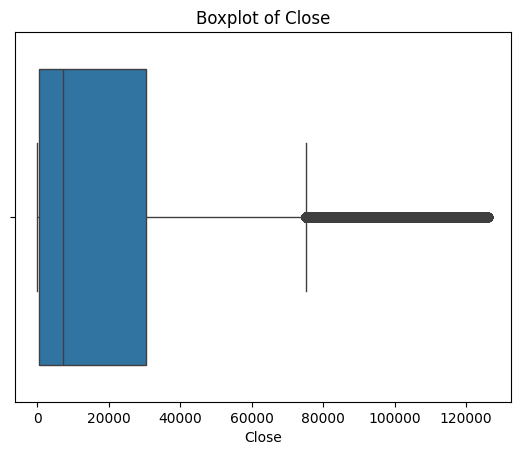

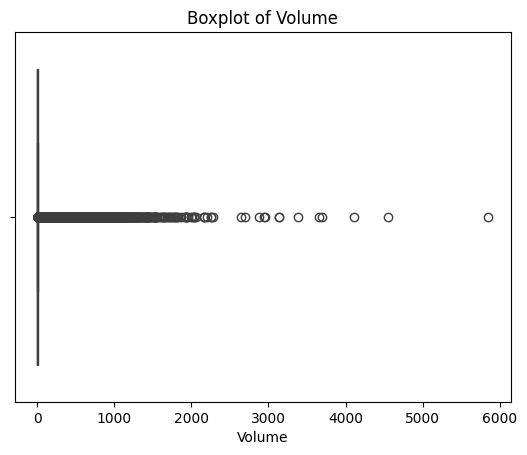

In [7]:
num_cols = data.select_dtypes(include=[np.number]).columns
for col in num_cols:
    q1, q3 = data[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [8]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')
data.set_index('Timestamp', inplace=True)
data.sort_index(inplace=True)
data

,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01 10:01:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 10:02:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 10:04:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 10:05:00,4.58,4.58,4.58,4.58,0.000000
...,...,...,...,...,...
2025-11-05 23:53:00,103975.00,103975.00,103882.00,103892.00,2.010327
2025-11-05 23:54:00,103897.00,103926.00,103883.00,103884.00,0.108666
2025-11-05 23:55:00,103869.00,103889.00,103851.00,103888.00,0.603795


In [9]:
data_1h = data.resample('1h').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})
data_1h

,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01 10:00:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 11:00:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 12:00:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 13:00:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 14:00:00,4.58,4.58,4.58,4.58,0.000000
...,...,...,...,...,...
2025-11-05 19:00:00,104358.00,104507.00,103986.00,104033.00,77.903019
2025-11-05 20:00:00,104009.00,104532.00,103670.00,103850.00,162.629616
2025-11-05 21:00:00,103824.00,103824.00,103509.00,103662.00,92.566820


In [10]:
def remove_obvious_errors_only(df):
    df_clean = df.copy()
    zero_prices = (df_clean['Close'] == 0).sum()
    df_clean['Close'].replace(0, np.nan, inplace=True)
    df_clean['Close'].fillna(method='ffill', inplace=True)
    print(f"Fixed {zero_prices} zero-price hours")

    inconsistent = (df_clean['High'] < df_clean['Low']).sum()
    if inconsistent > 0:
        # Swap if High < Low (data entry error)
        mask = df_clean['High'] < df_clean['Low']
        df_clean.loc[mask, ['High', 'Low']] = df_clean.loc[mask, ['Low', 'High']].values
        print(f"Fixed {inconsistent} OHLC inconsistencies")

    returns = df_clean['Close'].pct_change()
    next_returns = returns.shift(-1)

    spikes = ((returns > 1.0) & (next_returns < -0.5)) | \
             ((returns < -0.5) & (next_returns > 1.0))

    n_spikes = spikes.sum()
    if n_spikes > 0:
        df_clean.loc[spikes, 'Close'] = np.nan
        df_clean['Close'].interpolate(method='linear', inplace=True)
        print(f"Fixed {n_spikes} price spikes")

    neg_volume = (df_clean['Volume'] < 0).sum()
    df_clean['Volume'] = df_clean['Volume'].clip(lower=0)
    print(f"Fixed {neg_volume} negative volumes")

    return df_clean

data_cleaned = remove_obvious_errors_only(data_1h)
data_cleaned

Fixed 0 zero-price hours
Fixed 0 negative volumes


/tmp/ipython-input-1179792481.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Close'].replace(0, np.nan, inplace=True)
/tmp/ipython-input-1179792481.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

,Open,High,Low,Close,Volume
Timestamp,,,,,
2012-01-01 10:00:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 11:00:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 12:00:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 13:00:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 14:00:00,4.58,4.58,4.58,4.58,0.000000
...,...,...,...,...,...
2025-11-05 19:00:00,104358.00,104507.00,103986.00,104033.00,77.903019
2025-11-05 20:00:00,104009.00,104532.00,103670.00,103850.00,162.629616
2025-11-05 21:00:00,103824.00,103824.00,103509.00,103662.00,92.566820


In [12]:
data_cleaned.to_csv("/content/drive/MyDrive/Self Project/Crypto Price Prediction/data/processed/btcusd_1-min_data_clean.csv")